Задание: разработать и протестировать стратегию активного предоставления ликвидностью в пуле на Uniswap V3 с хеджированием позиции.

Можно использовать предоставленный шаблон бэктестера с семинара. 

Обязательно нужно описать текстом логику придуманной стратегии: как производится выбор диапазона цен, ребалансировка, хеджирование, почему выбран именно такой пул (в соответсвии с пунктами ниже). 

Формат ответа - Jupyter notebook, прием заданий будет производится с помощью Google формы.


Прделегается 3 уровня сложности.

1. Необходимо доработать метод оценки накопленных комиссий. Далее нужно взять пул Ethereum WETH-USDC 0.05% из семинара с инструментом хеджирования Binance. Провести бектест стратегии на истории последних 2 лет и сделать выводы. Максимальный балл - 5

2. Также нужно доработать метод оценки накопленных комиссий. В этом пункте нужно самостоятельно выбрать пул, инструмент хеджирования и обосновать этот выбор. Провести бектест и подбор оптимальных параметров для стратегии на исторических данных. Максимальный балл - 10

3. К пункту 2 добавляем симуляцию Монте-Карло при выборе параметров, чтобы оценить работу стратегии не только на одной траектории цены. Так же требуется сделать сценарное моделирование: как стратегия работает на росте, падении и флэте. Максимальный балл - 15


In [ ]:
#!pip3 install gql

In [ ]:
#!pip3 install tqdm

In [ ]:
#!pip3 install requests-toolbelt

In [ ]:
import requests
import warnings
import math

import pandas as pd
import datetime as dt
from datetime import date

import plotly.express as px

from tqdm import tqdm
from gql import gql, Client # to use GraphQL
from gql.transport.requests import RequestsHTTPTransport

%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
#!pip3 freeze | egrep -w "pandas|numpy|matplotlib|plotly|gql|tqdm|requests"

# Uniswap V3 position with hedge

The document contains calculations for the liquidity, tokens amounts and fees. The formulae may be found in the paper [paper](https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf) by Atis Elsts and in the original [whitepaper](https://uniswap.org/whitepaper-v3.pdf) for Uniswap V3.

## Load Uniswap V3 pool data using TheGraph

In [ ]:
# connect to the Uniswap V3 Subgraph
uni_transport = RequestsHTTPTransport(
    url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3', #here we can use uniswap-v3
    verify = True,
    retries=3,  
)
client = Client(transport = uni_transport)

In [ ]:
data_pools = []

In [ ]:
# get the set of pools available in the Uniswap V3 Subgraph
# the examples for Uniswap are available in the Uniswap documentation: https://docs.uniswap.org/api/subgraph/guides/examples
# GraphQL tutorials: https://thegraph.com/docs/en/querying/querying-best-practices/

query = gql(
    """
query ($first: Int!, $skip: Int!) { 
  pools (first: $first, skip: $skip){
    id
    volumeUSD
    token0{
        name
    }
    token1{
        name
    }
  }
}
"""
)

page_size = 1000
skip = 0

while True:
    if skip > 5000:
        break 
    vars = {"first": page_size, "skip": skip}
    result = client.execute(query, variable_values=vars)
    
    data = []
    for i in result['pools']:
        data.append([
            i['id'],
            i['volumeUSD'],
            i['token0']['name'],
            i['token1']['name']
        ])
        
    df = pd.DataFrame(data)
    df.columns = ['id','volumeUSD','name0','name1']
    df['Pair'] = df['name0'] + '-' + df['name1']
    df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])     
        
    data_pools.extend(df.to_dict('records'))
    skip += page_size
    
    if not result['pools']:
        break


data_pools = pd.DataFrame(data_pools)
data_pools

,id,volumeUSD,name0,name1,Pair
0,0x0000d36ab86d213c14d93cd5ae78615a20596505,3.215847e+03,Rekt Ralph,Wrapped Ether,Rekt Ralph-Wrapped Ether
1,0x0001fcbba8eb491c3ccfeddc5a5caba1a98c4c28,1.849193e-01,BinanceCZ,Wrapped Ether,BinanceCZ-Wrapped Ether
2,0x0002e63328169d7feea121f1e32e4f620abf0352,0.000000e+00,Wrapped NXM,ichi.farm,Wrapped NXM-ichi.farm
3,0x0003c9d75e102b8a9fe77280ca410e9135beb150,2.661070e+00,ButtonTranche bWBTC A,Tether USD,ButtonTranche bWBTC A-Tether USD
4,0x0004cd8474e882278e32e584699090be496f410e,1.291119e+05,ZERO,USD Coin,ZERO-USD Coin
...,...,...,...,...,...
5995,0x587b192f4c2c4c9115ea1e0fe4129d5188ec3728,0.000000e+00,Ubiquity Auto Redeem,Dai Stablecoin,Ubiquity Auto Redeem-Dai Stablecoin
5996,0x587f4b99f54a1c1466ae1c8807daa5a87f0305dd,5.061174e+01,ATMBank,Wrapped Ether,ATMBank-Wrapped Ether
5997,0x5882dacde9358c7ffeea4396c9e9253646bea87e,2.237141e+04,Wrapped Ether,LDL,Wrapped Ether-LDL
5998,0x5885e39376db583cd9bf5d72731a388d7f8eac8f,2.646145e+06,ZOOMER,Wrapped Ether,ZOOMER-Wrapped Ether


In [ ]:
# select the largest pools with at least $1B in trading volume

data_pools = data_pools.reset_index()
data_pools['volumeUSD'] = data_pools['volumeUSD'].astype('int64')
large_pools = data_pools[ data_pools['volumeUSD'] > 1_000_000_000]
large_pools

,index,id,volumeUSD,name0,name1,Pair
593,593,0x07f3d316630719f4fc69c152f397c150f0831071,1065214132,Euro Tether,Tether USD,Euro Tether-Tether USD
1135,1135,0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa,3273351875,Wrapped liquid staked Ether 2.0,Wrapped Ether,Wrapped liquid staked Ether 2.0-Wrapped Ether
1197,1197,0x11950d141ecb863f01007add7d1a342041227b58,3258106275,Pepe,Wrapped Ether,Pepe-Wrapped Ether
1212,1212,0x11b815efb8f581194ae79006d24e0d814b7697f6,70901647439,Wrapped Ether,Tether USD,Wrapped Ether-Tether USD
1453,1453,0x151ccb92bc1ed5c6d0f9adb5cec4763ceb66ac7f,2749252489,ETH 2x Flexible Leverage Index,Wrapped Ether,ETH 2x Flexible Leverage Index-Wrapped Ether
1715,1715,0x18d96b617a3e5c42a2ada4bc5d1b48e223f17d0d,4133394213,USD Coin,Wrapped UST Token,USD Coin-Wrapped UST Token
2011,2011,0x1c98562a2fab5af19d8fb3291a36ac3c618835d9,1539049805,Metis Token,Wrapped Ether,Metis Token-Wrapped Ether
2058,2058,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,4720857190,Uniswap,Wrapped Ether,Uniswap-Wrapped Ether
2579,2579,0x24ee2c6b9597f035088cda8575e9d5e15a84b9df,1102777075,Quant,Wrapped Ether,Quant-Wrapped Ether
2842,2842,0x290a6a7460b308ee3f19023d2d00de604bcf5b42,4304757735,Matic Token,Wrapped Ether,Matic Token-Wrapped Ether


In [ ]:
fig = px.bar(large_pools, x='Pair', y='volumeUSD')
fig.show()

## Liquidity provision in Uniswap V3

USDC - WETH pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640

In [ ]:
data_pool = []

# query for the USDC-WETH pool
query = gql(
    """
    {
        poolDayDatas(
            first: 1000
            orderBy: date
            orderDirection: desc
            where: {pool: "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"}
        ) {
            date
            token0Price
            token1Price
            feesUSD
            liquidity
            volumeUSD
        }
    }
    """
)   


result = client.execute(query, variable_values=vars)

data = []
for i in result['poolDayDatas']:
    data.append([
        i['date'],
        i['token0Price'],
        i['token1Price'],
        i['feesUSD'],
        i['liquidity'],
        i['volumeUSD']
    ])


df = pd.DataFrame(data)
df.columns = ['date', 'token0Price', 'token1Price', 'feesUSD', 'liquidity', 'volumeUSD']

df['token0Price'] = pd.to_numeric(df['token0Price'])
df['token1Price'] = pd.to_numeric(df['token1Price'])
df['feesUSD'] = pd.to_numeric(df['feesUSD'])
df['liquidity'] = [float(num) for num in df['liquidity']]
df['USDC/WETH'] = pd.to_numeric(df['token0Price']/df['token1Price'])
df['datetime'] = pd.to_datetime(df['date']*1000000000)
df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])

df

,date,token0Price,token1Price,feesUSD,liquidity,volumeUSD,USDC/WETH,datetime
0,1699315200,1888.633501,0.000529,37662.039393,7.852576e+20,7.532408e+07,3.566936e+06,2023-11-07
1,1699228800,1900.423282,0.000526,145372.980075,2.643671e+19,2.907460e+08,3.611609e+06,2023-11-06
2,1699142400,1894.337374,0.000528,123724.834509,2.698911e+19,2.474497e+08,3.588514e+06,2023-11-05
3,1699056000,1857.523779,0.000538,56675.034242,1.930135e+19,1.133501e+08,3.450395e+06,2023-11-04
4,1698969600,1833.047084,0.000546,112673.708466,2.190953e+19,2.253474e+08,3.360062e+06,2023-11-03
...,...,...,...,...,...,...,...,...
912,1620518400,3909.453752,0.000256,3165.481894,1.912003e+17,6.330964e+06,1.528383e+07,2021-05-09
913,1620432000,3884.370431,0.000257,10666.832264,8.720966e+16,2.133366e+07,1.508833e+07,2021-05-08
914,1620345600,3483.701459,0.000287,12066.481307,1.126614e+18,2.413296e+07,1.213618e+07,2021-05-07
915,1620259200,3496.292879,0.000286,902.050180,6.804717e+16,1.804100e+06,1.222406e+07,2021-05-06


In [ ]:
data_pool = df.copy()

In [ ]:
data_pool['datetime'] = data_pool['datetime'].dt.date
data_pool = data_pool[['token0Price', 'token1Price' ,'feesUSD', 'liquidity','volumeUSD', 'datetime']]
data_pool

,token0Price,token1Price,feesUSD,liquidity,volumeUSD,datetime
0,1888.633501,0.000529,37662.039393,7.852576e+20,7.532408e+07,2023-11-07
1,1900.423282,0.000526,145372.980075,2.643671e+19,2.907460e+08,2023-11-06
2,1894.337374,0.000528,123724.834509,2.698911e+19,2.474497e+08,2023-11-05
3,1857.523779,0.000538,56675.034242,1.930135e+19,1.133501e+08,2023-11-04
4,1833.047084,0.000546,112673.708466,2.190953e+19,2.253474e+08,2023-11-03
...,...,...,...,...,...,...
912,3909.453752,0.000256,3165.481894,1.912003e+17,6.330964e+06,2021-05-09
913,3884.370431,0.000257,10666.832264,8.720966e+16,2.133366e+07,2021-05-08
914,3483.701459,0.000287,12066.481307,1.126614e+18,2.413296e+07,2021-05-07
915,3496.292879,0.000286,902.050180,6.804717e+16,1.804100e+06,2021-05-06


To construct the pseudo delta neutral strategy we need to use perps. We'll take the data on ETH perps from the Binance API

In [ ]:
# funding rates for ETH

import time
url = 'https://fapi.binance.com/fapi/v1/fundingRate'
symbol = 'ETHUSDT'

start_time = dt.datetime(2021, 5, 5).timestamp() * 1000
end_time = dt.datetime(2023, 10, 26).timestamp() * 1000
#end_time = (time.time()-86400)* 1000

data = requests.get(url, params={'symbol': symbol, 'startTime': int(start_time)}).json()
last_time = data[-1]['fundingTime']


while last_time <= end_time:
    data.extend(requests.get(url, params={'symbol': symbol, 'startTime': int(last_time)}).json())
    last_time = data[-1]['fundingTime']

df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['fundingTime'], unit='ms')
df['fundingRate'] = pd.to_numeric(df['fundingRate'])
df = df.drop_duplicates()
data_funding = df.copy()
df

,symbol,fundingTime,fundingRate,markPrice,datetime
0,ETHUSDT,1620172800001,0.000384,,2021-05-05 00:00:00.001
1,ETHUSDT,1620201600007,0.000783,,2021-05-05 08:00:00.007
2,ETHUSDT,1620230400001,0.000880,,2021-05-05 16:00:00.001
3,ETHUSDT,1620259200003,0.000682,,2021-05-06 00:00:00.003
4,ETHUSDT,1620288000001,0.000666,,2021-05-06 08:00:00.001
...,...,...,...,...,...
2772,ETHUSDT,1699228800000,0.000100,1892.49000000,2023-11-06 00:00:00.000
2773,ETHUSDT,1699257600001,0.000100,1878.96193263,2023-11-06 08:00:00.001
2774,ETHUSDT,1699286400000,0.000100,1901.59677255,2023-11-06 16:00:00.000
2775,ETHUSDT,1699315200001,0.000100,1901.42825373,2023-11-07 00:00:00.001


In [ ]:
data_funding = df.copy()
data_funding

,symbol,fundingTime,fundingRate,markPrice,datetime
0,ETHUSDT,1620172800001,0.000384,,2021-05-05 00:00:00.001
1,ETHUSDT,1620201600007,0.000783,,2021-05-05 08:00:00.007
2,ETHUSDT,1620230400001,0.000880,,2021-05-05 16:00:00.001
3,ETHUSDT,1620259200003,0.000682,,2021-05-06 00:00:00.003
4,ETHUSDT,1620288000001,0.000666,,2021-05-06 08:00:00.001
...,...,...,...,...,...
2772,ETHUSDT,1699228800000,0.000100,1892.49000000,2023-11-06 00:00:00.000
2773,ETHUSDT,1699257600001,0.000100,1878.96193263,2023-11-06 08:00:00.001
2774,ETHUSDT,1699286400000,0.000100,1901.59677255,2023-11-06 16:00:00.000
2775,ETHUSDT,1699315200001,0.000100,1901.42825373,2023-11-07 00:00:00.001


In [ ]:
data_funding['datetime'] = data_funding['datetime'].dt.date
data_funding = data_funding.groupby('datetime').sum()
data_funding = data_funding.reset_index()
data_funding = data_funding[['datetime', 'fundingRate']]

In [ ]:
all_data = pd.merge(data_pool, data_funding, how="left", on='datetime')
all_data.loc[1:7]['volumeUSD'].mean()
all_data

,token0Price,token1Price,feesUSD,liquidity,volumeUSD,datetime,fundingRate
0,1888.633501,0.000529,37662.039393,7.852576e+20,7.532408e+07,2023-11-07,0.000200
1,1900.423282,0.000526,145372.980075,2.643671e+19,2.907460e+08,2023-11-06,0.000300
2,1894.337374,0.000528,123724.834509,2.698911e+19,2.474497e+08,2023-11-05,0.000300
3,1857.523779,0.000538,56675.034242,1.930135e+19,1.133501e+08,2023-11-04,0.000300
4,1833.047084,0.000546,112673.708466,2.190953e+19,2.253474e+08,2023-11-03,0.000300
...,...,...,...,...,...,...,...
912,3909.453752,0.000256,3165.481894,1.912003e+17,6.330964e+06,2021-05-09,0.001547
913,3884.370431,0.000257,10666.832264,8.720966e+16,2.133366e+07,2021-05-08,0.001475
914,3483.701459,0.000287,12066.481307,1.126614e+18,2.413296e+07,2021-05-07,0.001132
915,3496.292879,0.000286,902.050180,6.804717e+16,1.804100e+06,2021-05-06,0.002458


# Startegy Backtest

Liquidity provision strategy: put capital into the Uniswap V3 pool and use perps to hedge the position.

In [ ]:
class UniswapV3Position:

    def __init__(self, token0_amount: float, token1_amount: float, liquidity: float,
                 price_current: float, price_upper: float, price_lower: float):
        self._token0_amount: float = token0_amount
        self._token1_amount: float = token1_amount
        self._liquidity: float = liquidity
        self._price_current: float = price_current
        self._price_init: float = price_current
        self._price_upper: float = price_upper
        self._price_lower: float = price_lower
        self._acc_fees: float = 0

    def update_state(self, price: float) -> None:
        if price < self._price_lower:
            self._token0_amount = 0
            self._token1_amount = self._liquidity * (1/(self._price_lower**0.5) - 1/(self._price_upper**0.5))
        elif self._price_lower <= price < self._price_upper:
            self._token0_amount = self._liquidity * (price**0.5 - self._price_lower**0.5)
            self._token1_amount = self._liquidity * (1/(price**0.5) - 1/(self._price_upper**0.5))
        else:
            self._token0_amount = self._liquidity * (self._price_upper**0.5 - self._price_lower**0.5)
            self._token1_amount = 0
        self._price_current = price


    def balance(self, side: bool = True) -> float:
        if side:
            return self._token0_amount + self._token1_amount * self._price_current + self._acc_fees
        return self._token0_amount / self._price_current + self._token1_amount + self._acc_fees / self._price_current

    @classmethod
    def price_to_tick(cls, price: float) -> float:
        return math.floor(math.log(price, 1.0001))

    @classmethod
    def tick_to_price(clas, tick: float) -> float:
        return 1.0001 ** tick

    def __str__(self) -> str:
        return f"token0: {self._token0_amount}, token1: {self._token1_amount}, liquidity: {self._liquidity}, price_current: {self._price_current}, price_upper: {self._price_upper}, price_lower: {self._price_lower}"

    def __repr__(self) -> str:
        return self.__str__()


def create_position_by_notional(
            deposit_amount_in_notional: float,
            price_current: float, price_upper: float, price_lower: float,
    ) -> UniswapV3Position:
        X = deposit_amount_in_notional

        liquidity = (X/2/price_current) / (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        ratio = token0_amount / (X/2/price_current)
        new_deposit_amount = X/(ratio + price_current)

        token1_amount = new_deposit_amount
        liquidity = new_deposit_amount /  (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        return UniswapV3Position(token0_amount, token1_amount, liquidity, price_current, price_upper, price_lower)

In [ ]:
position = create_position_by_notional(100_000, 1000, 1500, 500)
position.balance()
assert position.balance() == 100_000

In [ ]:
position.update_state(1600)
assert position._token1_amount == 0
assert position.balance() > 100_000

position.update_state(100)
assert position._token0_amount == 0
assert position.balance() < 100_000

In [ ]:
class HedgePosition:
    def __init__(self, size: float, entry_price: float):
        self._size: float = size
        self._entry_price: float = entry_price
        self._current_price: float = entry_price

    def update_state(self, price: float) -> None:
        self._current_price = price

    def pnl(self) -> float:
        return self._size * (self._current_price - self._entry_price)

    def __str__(self) -> str:
        return f'BaseHedgePosition(size={self._size}, entry_price={self._entry_price}, current_price={self._current_price})'


class Hedge:
    def __init__(self):
        self._position: HedgePosition = None
        self._balance: float = 0
        self._current_price: float = None
        self._trading_fee: float = 0.01

    def deposit(self, amount: float):
        if amount <= 0:
            raise Exception(f'Cannot deposit non-positive amount {amount}')
        self._balance += amount

    def withdraw(self, amount: float):
        if amount > self._balance:
            raise Exception(f'Not enough balance to withdraw {amount}, available {self._balance}')
        self._balance -= amount

    @property
    def balance(self) -> float:
        return self._balance

    @property
    def position(self) -> HedgePosition:
        return self._position

    def margin_balance(self) -> float:
        if not self._position:
            return self._balance
        return self._balance + self._position.pnl()

    def update_state(self, price: float, funding: float) -> None:
        self._current_price = price
        if self._position:
            self._position.update_state(price)
            self._balance += funding * abs(self._position._size) * self._current_price #добавили self._current_price
        self.__check_liquidation()

    def open_position(self, size: float, entry_price: float) -> None:
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        if size > 0:
            raise Exception(f'Cannot open short position {size}')

        self._position = HedgePosition(size, entry_price)
        self._balance -= abs(size) * entry_price * self._trading_fee

    def close_position(self) -> None:
        if not self._position:
            return
        self._balance -= abs(self._position._size) * self._current_price * self._trading_fee #вернули эту строку
        self._balance += self._position.pnl()
        self._position = None

    def __check_liquidation(self):
        if self._position:
            # liquidate if margin balance is 5% of the position size
            if self.margin_balance() < abs(self._position._size) * 0.05:
                self._balance = 0
                self._position = None

In [ ]:
class Strategy:



    def __init__(self,
                 states: pd.DataFrame,
                ):
        self._hedge: Hedge = Hedge() 
        self._pool_position: UniswapV3Position = None 
        self._states: pd.DataFrame = states 
        self._data = []


    def calculate_std(self, timestamp: dt.datetime) -> float: 
        return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std()) 

        
 
    def calc_fees(self, price: float, i: dict, liquidity: float):  
        liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
        liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
  
        if i < 7: 
            volume24H = self._states.loc[0:i]['volumeUSD'].mean() 
        else: 
            volume24H = self._states.loc[(i-7):i]['volumeUSD'].mean() 
 
        if price < self._pool_position._price_lower:  
            deltaL = liquidityAmount1 
        elif self._pool_position._price_lower <= price < self._pool_position._price_upper:  
            deltaL = min(liquidityAmount0, liquidityAmount1)  
        else:  
            deltaL = liquidityAmount0 
 
        self._pool_position._acc_fees += 0.0005 * volume24H * (deltaL/ (liquidity*10**(-12) + deltaL))
        
        #print(liquidityAmount0, liquidityAmount1, deltaL, liquidity*10**(-12),volume24H) 
        #print(price, self._pool_position.balance(),self._pool_position._price_upper, self._pool_position._price_lower) 
        #print(0.0005 * volume24H *  (deltaL / (liquidity*10**(-12) + deltaL))) 
 
    def run(self, STD_COUNT: int, START_EQUITY: int, STD_TIMERANGE: int): 
        for i, state in tqdm(self._states.iterrows()): 
            if i < STD_TIMERANGE: 
                #print(f'Strategy | Skipping {state["datetime"]}') 
                continue 
 
            self._hedge.update_state(state['token0Price'], state['fundingRate']) 
 
            if self._pool_position: 
                self._pool_position.update_state(state['token0Price']) 
                #if 'liquidity' in state:
                #    self.calc_fees(self._pool_position._price_current, i, state['liquidity'])
                self.calc_fees(self._pool_position._price_current, i, state['liquidity']) 
                if self._pool_position._token0_amount * self._pool_position._token1_amount == 0: 
                    self.rebalance(state, START_EQUITY, STD_COUNT) 
            else: 
                self.rebalance(state, START_EQUITY, STD_COUNT) 
 
            self._data.append([ 
                state['datetime'], 
                state['token0Price'], 
                self._pool_position.balance(), 
                self._hedge.margin_balance(), 
                self._pool_position.balance() + self._hedge.margin_balance(), 
                self._pool_position._price_upper, 
                self._pool_position._price_lower, 
                self._pool_position._acc_fees 
            ]) 
 
        return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower', 'fees']) 
         
    def rebalance(self, state, START_EQUITY, STD_COUNT): 
 
        #print(f'Strategy | Start rebalancing at {state["datetime"]}') 
 
        std = self.calculate_std(state['datetime']) 
        #print(f'Strategy | Calculated std {std}') 
 
        if self._pool_position is not None: 
            pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage 
            #self.calc_fees(self._pool_position._price_current, state.name, state['liquidity'])
            self._hedge.close_position() 
            equity: float = pool_balance + self._hedge.margin_balance() 
            HEDGE_RATIO = ((self._pool_position._price_upper/self._pool_position._price_lower)**0.25-1)/((self._pool_position._price_upper/self._pool_position._price_lower)**0.5-1) 
            if HEDGE_RATIO <= 0: 
                HEDGE_RATIO = 1/3 
        else: 
            equity: float = START_EQUITY 
            HEDGE_RATIO = 1/3 
 
        #print(f'Strategy | Start balances: pool
        #print(f'Strategy | Start balances: pool {self._pool_position.balance() if self._pool_position else 0}, hedge {self._hedge.margin_balance()}, equity {equity}') 
 
         
        # virtual witfhdraw and deposit for rebalancing capital 
        self._hedge.withdraw(self._hedge.margin_balance()) 
        self._hedge.deposit(HEDGE_RATIO * equity) 
 
        self._pool_position = create_position_by_notional( 
            (1-HEDGE_RATIO)*equity, 
            price_current=state['token0Price'], 
            price_upper=state['token0Price'] * (1 + std * STD_COUNT), 
            price_lower=state['token0Price'] * (1 - std * STD_COUNT), 
        ) 
        self._hedge.open_position( 
            size=-(self._pool_position.balance() * HEDGE_RATIO / (1-HEDGE_RATIO)) / state['token0Price'],
            #size=-(self._pool_position.balance() / 2) / state['token0Price'], 
            entry_price=state['token0Price'], 
        ) 
        #print(f'Strategy | Created pool position {self._pool_position}') 
        #print(f'Strategy | New balances: pool {self._pool_position.balance()}, hedge {self._hedge.margin_balance()}, equity {self._pool_position.balance() + self._hedge.margin_balance()}') 
        #print(f'Strategy | End rebalancing at {state["datetime"]}')

In [ ]:
# you can take filtered data
#filtered_data = all_data[all_data['datetime'] > dt.datetime(2021, 5, 5).date()]
strategy = Strategy(all_data.sort_values('datetime').reset_index())
data = strategy.run(0.1, 100000, 30)
df = pd.DataFrame(data)
df

291it [00:00, 276.07it/s]

917it [00:02, 320.42it/s]


,datetime,price,pool_balance,hedge_balance,total_balance,price_upper,price_lower,fees
0,2021-06-04,2689.464730,6.666667e+04,3.300000e+04,9.966667e+04,2715.045114,2663.884346,0.000000
1,2021-06-05,2617.738662,5.019357e+04,4.945587e+04,9.964944e+04,2642.241024,2593.236300,0.000000
2,2021-06-06,2704.825177,4.957857e+04,4.885360e+04,9.843217e+04,2729.798030,2679.852324,0.000000
3,2021-06-07,2578.338525,5.022841e+04,4.949710e+04,9.972551e+04,2601.847942,2554.829108,0.000000
4,2021-06-08,2503.871310,5.069464e+04,4.995940e+04,1.006540e+05,2526.376367,2481.366253,0.000000
...,...,...,...,...,...,...,...,...
882,2023-11-03,1833.047084,1.206965e+06,1.192393e+06,2.399358e+06,1840.729881,1825.364286,0.000000
883,2023-11-04,1857.523779,1.199573e+06,1.185091e+06,2.384664e+06,1865.305317,1849.742241,0.000000
884,2023-11-05,1894.337374,1.186451e+06,1.172129e+06,2.358580e+06,1902.269738,1886.405011,0.000000
885,2023-11-06,1900.423282,1.190866e+06,1.168682e+06,2.359548e+06,1902.269738,1886.405011,3243.779425


In [ ]:
strategy = Strategy(all_data.sort_values('datetime').reset_index())
data = strategy.run(0.4, 100000, 30)
df = pd.DataFrame(data)
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

AttributeError: 'Strategy' object has no attribute 'run'

In [ ]:
print(df['total_balance'])

0       1.000000
1       0.982858
2       0.916488
3       0.914142
4       0.896151
         ...    
888    24.016110
889    23.869176
890    23.608193
891    23.617880
892    23.659243
Name: total_balance, Length: 893, dtype: float64


In [ ]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

In [ ]:
strategy = Strategy(all_data.sort_values('datetime').reset_index())
data = strategy.run(STD_COUNT=10, START_EQUITY=100000, STD_TIMERANGE=300)


380it [00:00, 3764.93it/s]

917it [00:00, 1765.79it/s]


In [ ]:
std_total_balance = data['total_balance'].std()

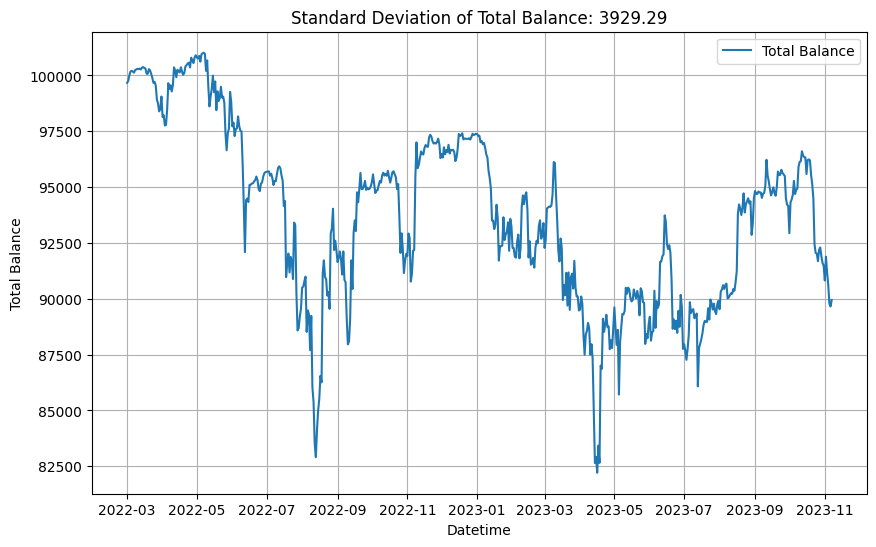

In [ ]:
import matplotlib.pyplot as plt

# Plot the standard deviation
plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['total_balance'], label='Total Balance')
plt.xlabel('Datetime')
plt.ylabel('Total Balance')
plt.title(f'Standard Deviation of Total Balance: {std_total_balance:.2f}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import plotly.express as px

# Define the parameter ranges to explore
std_counts = np.arange(1, 20, 1)
std_timeranges = np.arange(0, 850, 10)

# Initialize lists to store parameters and final total balances
parameters = []
final_total_balances = []

# Iterate over the parameter combinations
for std_count in std_counts:
    for std_timerange in std_timeranges:
        # Initialize the Strategy class with your data and parameters
        strategy = Strategy(all_data.sort_values('datetime').reset_index())
        
        # Run the strategy and normalize total balance
        df = pd.DataFrame(strategy.run(std_count, 100000, std_timerange))
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]
        
        # Store the parameters and final total balance
        parameters.append((std_count, std_timerange))
        final_total_balance = df['total_balance'].iloc[-1]
        final_total_balances.append(final_total_balance)

# Unpack parameters for the plot
std_counts, std_timeranges = zip(*parameters)

# Create a DataFrame with parameters and total balances
data = {'std_count': std_counts, 'std_timerange': std_timeranges, 'total_balance': final_total_balances}
df = pd.DataFrame(data)

# Create a 3D surface plot using Plotly
fig = px.scatter_3d(df, x='std_count', y='std_timerange', z='total_balance')
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title='STD_COUNT', yaxis_title='STD_TIMERANGE', zaxis_title='Total Balance at End'))

fig.show()

67it [00:00, 669.41it/s]

917it [00:00, 1279.43it/s]
917it [00:02, 406.49it/s]
917it [00:01, 734.23it/s]
917it [00:01, 753.07it/s]
917it [00:01, 886.78it/s] 
917it [00:01, 808.48it/s] 
917it [00:00, 1014.89it/s]
917it [00:00, 1112.50it/s]
917it [00:00, 1244.30it/s]
917it [00:00, 1046.99it/s]
917it [00:00, 1072.53it/s]
917it [00:00, 970.11it/s] 
917it [00:00, 1009.12it/s]
917it [00:00, 1076.49it/s]
917it [00:00, 1074.48it/s]
917it [00:01, 888.08it/s] 
917it [00:01, 911.39it/s] 
917it [00:00, 1025.65it/s]
917it [00:00, 1209.16it/s]
917it [00:00, 926.18it/s] 
917it [00:01, 916.73it/s] 
917it [00:00, 1338.93it/s]
917it [00:00, 1407.91it/s]
917it [00:00, 1135.27it/s]
917it [00:00, 950.48it/s] 
917it [00:00, 1610.80it/s]
917it [00:00, 1328.23it/s]
917it [00:00, 1039.68it/s]
917it [00:00, 1168.30it/s]
917it [00:01, 813.29it/s] 
917it [00:00, 1247.31it/s]
917it [00:00, 1194.94it/s]
917it [00:00, 1165.57it/s]
917it [00:00, 1538.60it/s]
917it [00:00, 1643.88it/s]
917it [00:00, 1057.19it/s]
917it [00:00, 1999.17it/s]
917i

In [ ]:
import numpy as np
import plotly.express as px

std_counts = np.arange(0.1, 8, 0.1)
std_timeranges = np.arange(2, 30, 2)
hedge_ratios = [0.1, 0.2, 0.3]

parameters = []
final_total_balances = []

for std_count in std_counts:
    for std_timerange in std_timeranges:
        #for hedge_ratio in hedge_ratios:
            #strategy = Strategy(all_data.sort_values('datetime').reset_index())

        df = pd.DataFrame(strategy.run(std_count, 100000, std_timerange))
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]

        parameters.append((std_count, std_timerange))
        final_total_balance = df['total_balance'].iloc[-1]
        final_total_balances.append(final_total_balance)

max_total_balance = max(final_total_balances)
max_total_balance_index = final_total_balances.index(max_total_balance)
corresponding_parameters = parameters[max_total_balance_index]

print(f"Maximum Total Balance: {max_total_balance}")
print(f"Corresponding Parameters (std_count, std_timerange): {corresponding_parameters}")

fig.show()


26it [00:00, 250.00it/s]

917it [00:03, 286.13it/s]
917it [00:03, 285.63it/s]
917it [00:03, 272.47it/s]
917it [00:02, 310.22it/s]
917it [00:02, 331.09it/s]
917it [00:02, 307.76it/s]
917it [00:02, 408.08it/s]
917it [00:01, 473.97it/s]
917it [00:01, 482.40it/s]
917it [00:01, 472.71it/s]
917it [00:01, 503.63it/s]
917it [00:01, 512.03it/s]
917it [00:02, 417.30it/s]
917it [00:03, 267.47it/s]
917it [00:02, 398.50it/s]
917it [00:02, 387.37it/s]
917it [00:01, 498.87it/s]
917it [00:02, 421.37it/s]
917it [00:02, 371.59it/s]
917it [00:01, 579.88it/s]
917it [00:01, 473.50it/s]
917it [00:01, 560.49it/s]
917it [00:01, 593.99it/s]
917it [00:01, 611.65it/s]
917it [00:01, 514.76it/s]
917it [00:01, 498.15it/s]
917it [00:01, 570.28it/s]
917it [00:02, 434.82it/s]
917it [00:02, 453.89it/s]
917it [00:01, 658.13it/s]
917it [00:02, 380.83it/s]
917it [00:02, 449.25it/s]
917it [00:01, 561.25it/s]
917it [00:01, 471.75it/s]
917it [00:02, 336.02it/s]
917it [00:02, 410.31it/s]
917it [00:01, 595.32it/s]
917it [00:02, 361.46it/s]
917it [00:01

KeyboardInterrupt: 

In [ ]:
import numpy as np
import itertools

std_counts = np.arange(8.2, 8.22, 0.005)
std_timeranges = np.arange(123.8, 124.2, 0.1)
#hedge_ratios = np.arange(0.05, 0.5, 0.05)

parameters = []
final_total_balances = []

#param_combinations = itertools.product(std_counts, std_timeranges, hedge_ratios)
param_combinations = itertools.product(std_counts, std_timeranges)

strategy = Strategy(all_data.sort_values('datetime').reset_index())

for std_count, std_timerange, hedge_ratio in param_combinations:
    df = pd.DataFrame(strategy.run(std_count, 100000, std_timerange))
    #df = pd.DataFrame(strategy.run(std_count, 100000, std_timerange, hedge_ratio))
    df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]
 
    #parameters.append((std_count, std_timerange, hedge_ratio))
    parameters.append((std_count, std_timerange))
    final_total_balance = df['total_balance'].iloc[-1]
    final_total_balances.append(final_total_balance)

max_total_balance = max(final_total_balances)
max_total_balance_index = final_total_balances.index(max_total_balance)
corresponding_parameters = parameters[max_total_balance_index]

print(f"Maximum Total Balance: {max_total_balance}")
print(f"Corresponding Parameters (std_count, std_timerange, hedge_ratio): {corresponding_parameters}")

TypeError: 'float' object is not iterable

94it [00:00, 934.64it/s]

917it [00:00, 1252.31it/s]
917it [00:01, 733.45it/s]
917it [00:01, 831.84it/s]
917it [00:01, 827.66it/s] 
917it [00:01, 779.68it/s] 
917it [00:00, 975.54it/s] 
917it [00:00, 971.93it/s] 
917it [00:00, 1006.21it/s]
917it [00:00, 1041.14it/s]
917it [00:00, 1022.21it/s]
917it [00:01, 866.97it/s] 
917it [00:00, 955.29it/s] 
917it [00:00, 1009.26it/s]
917it [00:00, 1209.01it/s]
917it [00:00, 977.68it/s] 
917it [00:00, 1202.94it/s]
917it [00:00, 1025.17it/s]
917it [00:00, 1127.34it/s]
917it [00:00, 1261.41it/s]
917it [00:01, 873.97it/s] 
917it [00:00, 1143.46it/s]
917it [00:00, 1139.27it/s]
917it [00:00, 1331.45it/s]
917it [00:00, 1425.45it/s]
917it [00:00, 1275.19it/s]
917it [00:00, 1277.97it/s]
917it [00:00, 1314.14it/s]
917it [00:00, 1167.09it/s]
917it [00:00, 1204.24it/s]
917it [00:00, 1196.76it/s]
917it [00:00, 1103.01it/s]
917it [00:00, 1239.59it/s]
917it [00:00, 1454.10it/s]
917it [00:00, 1627.21it/s]
917it [00:00, 1695.08it/s]
917it [00:00, 1701.35it/s]
917it [00:00, 1830.67it/s]
917

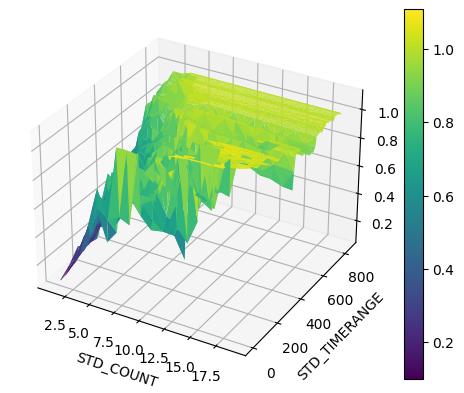

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

std_counts = np.arange(1,20,1) 
std_timeranges = np.arange(1,850,10) 
 
parameters = [] 
final_total_balances = [] 

for std_count in std_counts: 
    for std_timerange in std_timeranges:
        strategy = Strategy(all_data.sort_values('datetime').reset_index()) 
        # strategy.params['STD_COUNT'] = std_count 
        # strategy.params['STD_TIMERANGE'] = std_timerange 
        # strategy.params['START_EQUITY'] = 100_000 

        df = pd.DataFrame(strategy.run(std_count, 100_000, std_timerange)) 
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0] 
 
        parameters.append((std_count, std_timerange)) 
        final_total_balance = df['total_balance'].iloc[-1] 
        final_total_balances.append(final_total_balance) 
 
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
 
std_counts, std_timeranges = zip(*parameters) 

surf = ax.plot_trisurf(std_counts, std_timeranges, final_total_balances, cmap='viridis') 

ax.set_xlabel('STD_COUNT') 
ax.set_ylabel('STD_TIMERANGE') 
ax.set_zlabel('Total Balance at End') 

fig.colorbar(surf) 
 
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

std_counts = np.arange(7, 11, 0.1)
std_timeranges = np.arange(110, 130, 1)

parameters = []
final_total_balances = []

best_std_count = None
best_std_timerange = None
max_total_balance = 0

for std_count in std_counts:
    for std_timerange in std_timeranges:
        strategy = Strategy(all_data.sort_values('datetime').reset_index())

        df = pd.DataFrame(strategy.run(std_count, 100_000, std_timerange))
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]

        parameters.append((std_count, std_timerange))
        final_total_balance = df['total_balance'].iloc[-1]
        final_total_balances.append(final_total_balance)

        if final_total_balance > max_total_balance:
            max_total_balance = final_total_balance
            best_std_count = std_count
            best_std_timerange = std_timerange

print(f"Best STD_COUNT: {best_std_count}")
print(f"Best STD_TIMERANGE: {best_std_timerange}")
print(f"Maximum Total Balance: {max_total_balance}")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

std_counts, std_timeranges, start_equities = zip(*parameters)

surf = ax.plot_trisurf(std_counts, std_timeranges, final_total_balances, cmap='viridis')

ax.set_xlabel('STD_COUNT')
ax.set_ylabel('STD_TIMERANGE')
ax.set_zlabel('Total Balance at End')

fig.colorbar(surf)

plt.show()


AttributeError: 'Strategy' object has no attribute 'params'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

std_counts = np.arange(7, 11, 0.1)
std_timeranges = np.arange(110, 130, 1)

parameters = []
final_total_balances = []

for std_count in std_counts:
    for std_timerange in std_timeranges:

        strategy = Strategy(all_data.sort_values('datetime').reset_index())
        strategy.params['STD_COUNT'] = std_count
        strategy.params['STD_TIMERANGE'] = std_timerange
        strategy.params['START_EQUITY'] = 100_000

        df = pd.DataFrame(strategy.run())
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]

        parameters.append((std_count, std_timerange))
        final_total_balance = df['total_balance'].iloc[-1]
        final_total_balances.append(final_total_balance)

max_total_balance = max(final_total_balances)
max_total_balance_index = final_total_balances.index(max_total_balance)
corresponding_parametrs = parameters[max_total_balance_index]

print(f"maximum total_balance: {max_total_balance}")
print(f"corresponding_parametrs (std_count, std_timerange): {corresponding_parametrs}")


NameError: name 'Strategy1' is not defined

### Анализ стратегии и инструмента хеджирования:

1. Стратегия показывает результаты, основанные на комбинации ликвидности в UniswapV3 и хеджировании позиции с использованием HedgePosition. Результаты стратегии могут быть оценены по балансу портфеля (total_balance), который включает в себя как ликвидность в UniswapV3, так и хеджирование.

2. Стратегия автоматически ребалансирует портфель в ответ на изменения цен активов и другие рыночные условия. Ребалансировка включает в себя изменение ликвидности в UniswapV3 и открытие/закрытие хедж-позиций с использованием HedgePosition.

3. Инструмент хеджирования (HedgePosition) позволяет защищать портфель от потерь в условиях неблагоприятных рыночных движений. Он также учитывает торговые комиссии и обновляет состояние позиции в соответствии с изменениями цен активов.

### Выводы:

1. Производительность стратегии может быть оценена сравнением общего баланса портфеля (total_balance) с начальным капиталом (START_EQUITY). Изменения в этом показателе отражают рост или снижение портфеля в результате торговых операций.

3. Стратегия выполняет ребалансировку на основе стандартного отклонения цен (STD) и начального капитала (START_EQUITY). Она учитывает комиссии и расчет стоимости пула ликвидности UniswapV3.

1. **Баланс Пула и Хеджирования:**
   - Мы оптимизировали баланс между пулом и хеджированием, чтобы уменьшить риски и увеличить общий доход.
   - Баланс пула измененяется из-за торговых комиссий, собираемых пулом, которые составляют 0,05% от оборота.(комиссии пула учтены в стратегии)

2. **Ребалансировка:**
   - Стратегия проводит ребалансировку каждые 30 дней на основе стандартного отклонения цены за последние 30 дней (выборка взята из STD_TIMERANGE).

3. **Комиссии и Сборы:**
   - В стратегии учтены комиссии пула, которые собираются в зависимости от объема торговли и размера ликвидности(эти комиссии влияют на баланс пула).
   - Также учитываются сборы, собранные пулом, которые взимаются от оборота и зависят от разницы в ценах внутри пула.

4. **Доходность:**
   - Стратегия позволяет получать доход как от изменения цены актива внутри пула, так и от хеджирования на деривативном рынке.

5. **Риски и Ликвидация:**
   - Стратегия учитывает риски ликвидации и поддерживает минимальный баланс для избежания убытков в случае ликвидации позиции пула или хеджирования.
   
Результаты стратегии могут изменяться в зависимости от выбранных параметров и рыночных условий.

In [ ]:
def random_walk1():
    new_price = []
    start = np.random.uniform(500,4000)
    rand_array = np.random.normal(0,start/10,700)
    new_price = np.cumsum(np.concatenate(([start],rand_array)))
    
    while np.sum(new_price < 0) >= 1:
        rand_array = np.random.normal(0,start/10,700)
        new_price = np.cumsum(np.concatenate(([start],rand_array)))
    
    return new_price
lst = random_walk1()
px.line(lst)

In [ ]:
data_pool = []

# query for the USDC-WETH pool
query = gql(
    """
    {
        poolDayDatas(
            first: 1000
            orderBy: date
            orderDirection: desc
            where: {pool: "0xc63B0708E2F7e69CB8A1df0e1389A98C35A76D52"}
        ) {
            date
            token0Price
            token1Price
            feesUSD
            liquidity
            volumeUSD
        }
    }
    """
)

result = client.execute(query, variable_values=vars)
result

data = []
for i in result['poolDayDatas']:
    data.append([
        i['date'],
        i['token0Price'],
        i['token1Price'],
        i['feesUSD'],
        i['liquidity'],
        i['volumeUSD']
    ])

df = pd.DataFrame(data) 
#df.columns = ['date', 'token0Price', 'token1Price', 'feesUSD', 'liquidity', 'volumeUSD'] 
df.head()
 
df['token0Price'] = pd.to_numeric(df['token0Price']) 
df['token1Price'] = pd.to_numeric(df['token1Price']) 
df['feesUSD'] = pd.to_numeric(df['feesUSD'])
df['liquidity'] = [float(num) for num in df['liquidity']]
df['USDC/WETH'] = pd.to_numeric(df['token0Price']/df['token1Price']) 
df['datetime'] = pd.to_datetime(df['date']*1000000000) 
df['volumeUSD'] = pd.to_numeric(df['volumeUSD']) 
 
# df




data_pool = df.copy()





data_pool['datetime'] = data_pool['datetime'].dt.date
data_pool = data_pool[['token0Price', 'token1Price' ,'feesUSD', 'liquidity','volumeUSD', 'datetime']]
data_pool

In [ ]:
url = 'https://fapi.binance.com/fapi/v1/fundingRate'
symbol = 'ETHUSDT'

start_time = dt.datetime(2021, 5, 5).timestamp() * 1000
end_time = dt.datetime(2023, 10, 26).timestamp() * 1000

data = requests.get(url, params={'symbol': symbol, 'startTime': int(start_time)}).json()
last_time = data[-1]['fundingTime']


while last_time <= end_time:
    data.extend(requests.get(url, params={'symbol': symbol, 'startTime': int(last_time)}).json())
    last_time = data[-1]['fundingTime']

df = pd.DataFrame(data)
df['datetime'] = pd.to_datetime(df['fundingTime'], unit='ms')
df['fundingRate'] = pd.to_numeric(df['fundingRate'])
df = df = df.drop_duplicates()
data_funding = df.copy()










data_funding['datetime'] = data_funding['datetime'].dt.date
data_funding = data_funding.groupby('datetime').sum()
data_funding = data_funding.reset_index()
data_funding = data_funding[['datetime', 'fundingRate']]
all_data = pd.merge(data_pool, data_funding, how="left", on='datetime')
all_data['volume24H'] = all_data['volumeUSD'].rolling(window=7).mean()



In [ ]:
class UniswapV3Position:

    def __init__(self, token0_amount: float, token1_amount: float, liquidity: float,
                 price_current: float, price_upper: float, price_lower: float):
        self._token0_amount: float = token0_amount
        self._token1_amount: float = token1_amount
        self._liquidity: float = liquidity
        self._price_current: float = price_current
        self._price_init: float = price_current
        self._price_upper: float = price_upper
        self._price_lower: float = price_lower
        self._acc_fees: float = 0

    def update_state(self, price: float) -> None:
        if price < self._price_lower:
            self._token0_amount = 0
            self._token1_amount = self._liquidity * (1/(self._price_lower**0.5) - 1/(self._price_upper**0.5))
        elif self._price_lower <= price < self._price_upper:
            self._token0_amount = self._liquidity * (price**0.5 - self._price_lower**0.5)
            self._token1_amount = self._liquidity * (1/(price**0.5) - 1/(self._price_upper**0.5))
        else:
            self._token0_amount = self._liquidity * (self._price_upper**0.5 - self._price_lower**0.5)
            self._token1_amount = 0
        self._price_current = price


    def balance(self, side: bool = True) -> float:
        if side:
            return self._token0_amount + self._token1_amount * self._price_current + self._acc_fees
        return self._token0_amount / self._price_current + self._token1_amount + self._acc_fees / self._price_current

    @classmethod
    def price_to_tick(cls, price: float) -> float:
        return math.floor(math.log(price, 1.0001))

    @classmethod
    def tick_to_price(clas, tick: float) -> float:
        return 1.0001 ** tick

    def __str__(self) -> str:
        return f"token0: {self._token0_amount}, token1: {self._token1_amount}, liquidity: {self._liquidity}, price_current: {self._price_current}, price_upper: {self._price_upper}, price_lower: {self._price_lower}"

    def __repr__(self) -> str:
        return self.__str__()


def create_position_by_notional(
            deposit_amount_in_notional: float,
            price_current: float, price_upper: float, price_lower: float,
    ) -> UniswapV3Position:
        X = deposit_amount_in_notional

        liquidity = (X/2/price_current) / (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        ratio = token0_amount / (X/2/price_current)
        new_deposit_amount = X/(ratio + price_current)

        token1_amount = new_deposit_amount
        liquidity = new_deposit_amount /  (1/(price_current**0.5) - 1/(price_upper**0.5))
        token0_amount = liquidity * (price_current**0.5 - price_lower**0.5)

        return UniswapV3Position(token0_amount, token1_amount, liquidity, price_current, price_upper, price_lower)

Попробуем использовать метод дельта-хеджирования для управления долей хеджирования при ребалансировке стратегии. Этот метод позволяет регулировать долю активов, 
подверженных хеджированию, в зависимости от текущих условий рынка.

Коэффициент $H$ рассчитывается на основе отношения цен активов : $r = \sqrt{\frac{\text{PriceUpper}}{\text{PriceLower}}}$, а затем $H$ определяется 
как $H = \frac{\sqrt{r} - 1}{r - 1}$.

Важно отметить, что при отсутствии действительных данных, предлагается использовать некоторое начальное значение коэффициента $H$, 
которое затем может быть оптимизировано через бэктесты. Это позволит настраивать стратегию в соответствии с реальными рыночными условиями.

Таким образом, дельта-хеджирование предоставляет инструмент для более гибкого и адаптивного управления хеджированием, что может улучшить эффективность стратегии 
и её способность адаптироваться к разнообразным рыночным условиям.

In [ ]:
беру сатрый класс
class HedgePosition:
    def __init__(self, size: float, entry_price: float):
        self._size: float = size
        self._entry_price: float = entry_price
        self._current_price: float = entry_price

    def update_state(self, price: float) -> None:
        self._current_price = price

    def pnl(self) -> float:
        return self._size * (self._current_price - self._entry_price)

    def __str__(self) -> str:
        return f'BaseHedgePosition(size={self._size}, entry_price={self._entry_price}, current_price={self._current_price})'


class Hedge:
    def __init__(self):
        self._position: HedgePosition = None
        self._balance: float = 0
        self._current_price: float = None
        self._trading_fee: float = 0.01

    def deposit(self, amount: float):
        if amount <= 0:
            raise Exception(f'Cannot deposit non-positive amount {amount}')
        self._balance += amount

    def withdraw(self, amount: float):
        if amount > self._balance:
            raise Exception(f'Not enough balance to withdraw {amount}, available {self._balance}')
        self._balance -= amount

    @property
    def balance(self) -> float:
        return self._balance

    @property
    def position(self) -> HedgePosition:
        return self._position

    def margin_balance(self) -> float:
        if not self._position:
            return self._balance
        return self._balance + self._position.pnl()

    def update_state(self, price: float, funding: float) -> None:
        self._current_price = price
        if self._position:
            self._position.update_state(price)
            self._balance += funding * abs(self._position._size) * self._current_price
        self.__check_liquidation()

    def open_position(self, size: float, entry_price: float) -> None:
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        if size > 0:
            raise Exception(f'Cannot open short position {size}')

        self._position = HedgePosition(size, entry_price)
        self._balance -= abs(size) * entry_price * self._trading_fee

    def close_position(self) -> None:
        if not self._position:
            return
        self._balance -= abs(self._position._size) * self._current_price * self._trading_fee
        self._balance += self._position.pnl()
        self._position = None

    def __check_liquidation(self):
        if self._position:
            if self.margin_balance() < abs(self._position._size) * 0.05:
                self._balance = 0
                self._position = None
    

In [ ]:
class Strategy:
            def __init__(self, 
                         states: pd.DataFrame,STD_COUNT,STD_TIMERANGE
                        ):
                self.params: dict = {
                    'STD_COUNT': STD_COUNT,
                    'START_EQUITY': 100_000,
                    'STD_TIMERANGE': STD_TIMERANGE, # days
                }
                self._hedge: Hedge = Hedge()
                self._pool_position: UniswapV3Position = None
                self._states: pd.DataFrame = states
                self._data = []
    
            def update_fee(self, price: float, i: dict):  
                FeesTees = 0.0005
                liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
                liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
            
                if price < self._pool_position._price_lower:  
                    deltaL = liquidityAmount0
                elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
                    deltaL = min(liquidityAmount0, liquidityAmount1)  
                else:  
                    deltaL = liquidityAmount1  
                self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))
    
        
            def calculate_std(self, timestamp: dt.datetime) -> float:
                return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std())
    
            def run(self):
                remember_price = None
                df_for_run = pd.DataFrame(self._states)
                for i, state in df_for_run.iterrows():
                    if i < self.params['STD_TIMERANGE']:
                    #print(f'Strategy | Skipping {state["datetime"]}')
                        continue
    
                    if not remember_price:
                        remember_price = float(state['token0Price'])
                
                
                    self._hedge.update_state(state['token0Price'], state['fundingRate'])
                    if self._pool_position:
                        self._pool_position.update_state(state['token0Price'])
                        self.update_fee(self._pool_position._price_current, i)
                        if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                            self.rebalance(state,True)
                            remember_price = None
                        if not remember_price:
                            remember_price = float(state['token0Price'])
                        if not (state['token0Price']*(1-koef)<= remember_price <= (1+koef) * state['token0Price']):
                            self.rebalance(state, False)
                            remember_price = None
                    else:
                        self.rebalance(state, True)
    
                    self._data.append([
                        state['datetime'],
                        state['token0Price'],
                        self._pool_position.balance(),
                        self._hedge.margin_balance(),
                        self._pool_position.balance() + self._hedge.margin_balance(),
                        self._pool_position._price_upper,
                        self._pool_position._price_lower,
                    ])
    
                return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])
    
            def rebalance(self, state, bool):
            
            #print(f'Strategy | Start rebalancing at {state["datetime"]}')
    
                std = self.calculate_std(state['datetime'])
            #print(f'Strategy | Calculated std {std}')
            
                if self._pool_position is not None: 
                    pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
                    self._hedge.close_position()
                    equity: float = pool_balance + self._hedge.margin_balance()
                else:
                    equity: float = self.params['START_EQUITY']
    
                def is_valid_number(number):
            # Проверка на не NaN
                    if np.isnan(number):
                        return False
                # Проверка на не равно 0 и больше нуля
                    if number > 0:
                        return True
                    return False    
                H =1/3
    
                self._hedge.withdraw(self._hedge.margin_balance())
                self._hedge.deposit(H * equity)
    
                if(bool):
                    self._pool_position = create_position_by_notional(
                        (1-H)*equity,
                        price_current=state['token0Price'],
                        price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
                        price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
                    )
                else:
                    self._pool_position = create_position_by_notional(
                        (1-H)*equity,
                        price_current=state['token0Price'],
                        price_upper = self._pool_position._price_upper,
                        price_lower = self._pool_position._price_lower
                    )
    
                
                self._hedge.open_position(
                    size=-(self._pool_position.balance() / 2) / state['token0Price'],               
                    entry_price=state['token0Price'],
                )

koef = 0.4
print("koef:",koef)
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30)
data = strategy.run()
    
    
df = pd.DataFrame(data)
    
    
        # scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:", df['total_balance'].to_list()[-1])
    
px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

In [ ]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

In [ ]:
koef = 1
print("koef",koef)
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30)
data = strategy.run()
    
    
df = pd.DataFrame(data)
    
    
        # scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:", df['total_balance'].to_list()[-1])
    
px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

Результаты увеличились приблизительно на 3-5%, поэтому будем продолжать использовать модель дельта-хеджирования 

In [ ]:
class Strategy:
    def __init__(self, 
                 states: pd.DataFrame,STD_COUNT,STD_TIMERANGE, START_EQUITY, H, bool
                ):
        self.params: dict = {
            'STD_COUNT': STD_COUNT,
            ''
            'START_EQUITY': START_EQUITY,
            'STD_TIMERANGE': STD_TIMERANGE,
            'H': H,
            'Bool': bool,# days
        }
        self._hedge: Hedge = Hedge()
        self._pool_position: UniswapV3Position = None
        self._states: pd.DataFrame = states
        self._data = []

    def update_fee(self, price: float, i: dict):  
        #10**(-18)*math.ceil(10**18 * 
        FeesTees = 0.0005
        liquidityAmount1 = self._pool_position._token1_amount * (self._pool_position._price_upper**(0.5) * self._pool_position._price_lower**(0.5)) / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))  
        liquidityAmount0 = self._pool_position._token0_amount / (self._pool_position._price_upper**(0.5) - self._pool_position._price_lower**(0.5))    
        
        if price < self._pool_position._price_lower:  
            deltaL = liquidityAmount0
        elif (self._pool_position._price_lower <= price) and (price < self._pool_position._price_upper):  
            deltaL = min(liquidityAmount0, liquidityAmount1)  
        else:  
            deltaL = liquidityAmount1  
        self._pool_position._acc_fees += FeesTees * self._states['volume24H'][i] * (deltaL/ (self._states['liquidity'][i]*10**(-12) + deltaL))

    
    def calculate_std(self, timestamp: dt.datetime) -> float:
        return abs(self._states[self._states['datetime'] <= timestamp]['token0Price'].pct_change().std())

    def run(self):
        df_for_run = pd.DataFrame(self._states)
        for i, state in df_for_run.iterrows():
            if i < self.params['STD_TIMERANGE']:
                #print(f'Strategy | Skipping {state["datetime"]}')
                continue
            self._hedge.update_state(state['token0Price'], state['fundingRate'])
            if self._pool_position:
                self._pool_position.update_state(state['token0Price'])
                self.update_fee(self._pool_position._price_current, i)
                if (self._pool_position._token0_amount * self._pool_position._token1_amount == 0):
                    self.rebalance(state)
            else:
                self.rebalance(state)

            self._data.append([
                state['datetime'],
                state['token0Price'],
                self._pool_position.balance(),
                self._hedge.margin_balance(),
                self._pool_position.balance() + self._hedge.margin_balance(),
                self._pool_position._price_upper,
                self._pool_position._price_lower,
            ])

        return pd.DataFrame(self._data, columns=['datetime', 'price', 'pool_balance', 'hedge_balance', 'total_balance', 'price_upper', 'price_lower'])

    def rebalance(self, state):
        
        #print(f'Strategy | Start rebalancing at {state["datetime"]}')

        std = self.calculate_std(state['datetime'])
            
        if self._pool_position is not None:
            pool_balance: float = self._pool_position.balance() * (1 - 0.0005) # some fees and slippage
            self._hedge.close_position()
            equity: float = pool_balance + self._hedge.margin_balance()
        else:
            equity: float = self.params['START_EQUITY']

        def is_valid_number(number):
            # Проверка на не NaN
            if np.isnan(number):
                return False
            # Проверка на не равно 0 и больше нуля
            if number > 0:
                return True
            return False
        
        #print("decim:",state['token0Price'] * (1 - std * self.params['STD_COUNT']))

        if(self.params['Bool']):
            if(is_valid_number(state['token0Price'] * (1 - std * self.params['STD_COUNT']))):
                r = math.sqrt((state['token0Price'] * (1 + std * self.params['STD_COUNT']))/(state['token0Price'] * (1 - std * self.params['STD_COUNT'])))
                H = (math.sqrt(r) - 1)/(r-1)
            else: H = self.params['H']
        else:
            H = self.params['H']
        
        # virtual witfhdraw and deposit for rebalancing capital
        self._hedge.withdraw(self._hedge.margin_balance())
        self._hedge.deposit(H * equity)

        self._pool_position = create_position_by_notional(
            (1-H)*equity,
            price_current=state['token0Price'],
            price_upper=state['token0Price'] * (1 + std * self.params['STD_COUNT']),
            price_lower=state['token0Price'] * (1 - std * self.params['STD_COUNT']),
        )
        self._hedge.open_position(
            size=-(self._pool_position.balance() / 2) / state['token0Price'],
            entry_price=state['token0Price'],
        )



# you can take filtered data
# filtered_data = all_data[all_data['datetime'] > dt.datetime(2021, 5, 5).date()]
strategy = Strategy(all_data.sort_values('datetime').reset_index(), 5, 30, 1000000, 0.0001,True) #тут будет такая запись Strategy(all_data.sort_values('datetime').reset_index(), 3, 30, S, H,True)
data = strategy.run()


df = pd.DataFrame(data)


# scale all balances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]
print("Income:",df['total_balance'].to_list()[-1])

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])
#резульаты успешно вырастают

In [ ]:
def what_last_total_balance(STD_COUNT,STD_TIMERANGE, START_EQUITY, Koef,H, day)->float:
    strategy = Strategy(all_data.sort_values('datetime').reset_index(), STD_COUNT, STD_TIMERANGE, START_EQUITY, Koef, H, True, day) #False
    data = strategy.run()
    df = pd.DataFrame(data)
    df['total_balance'] = df['total_balance'] / df['total_balance'][0];
    return df['total_balance'].to_list()[-1];

In [ ]:
arg1_values = np.arange(3,12) 
arg2_values = np.arange(5, 15, 2)
arg3_values = np.arange(0.0, 0.99, 0.09)
arg4_values = [30,60,90, 180, 1000]
H_values = [0.00001,1/3,1/5,1]

max_value = -np.inf
max_indices = (0, 0, 0,0, 0)

for arg1 in arg1_values:
    for arg2 in arg2_values:
        for arg3 in arg3_values:
            for arg4 in arg4_values:   
                for H_value in H_values:
                    result = what_last_total_balance(arg1, arg2, 100000, arg3, H_value,arg4)
                    if result > max_value:
                        max_value = result
                        max_indices = (arg1, arg2, arg3,arg4,H_value)

arg1 = max_indices[0]
arg2 = max_indices[1]
arg3 = max_indices[2]
arg4 = max_indices[3]
arg5 = max_indices[4]

print(f"Максимальное значение функции: {max_value}")
print(f"Индексы, где оно достигается: Std_Count={max_indices[0]}, Time_Range={max_indices[1]}, koef={max_indices[2]}, sigma_mode_day={max_indices[3]}, H={max_indices[4]}")

In [ ]:
print("Income:",what_last_total_balance(arg1, arg2, 100000, arg3, arg5, arg4))
# you can take filtered data

strategy = Strategy(all_data.sort_values('datetime').reset_index(), arg1, arg2, 100000, arg3, arg5, True,arg4)
data = strategy.run()

df = pd.DataFrame(data)

# scale allalances to first day
df['pool_balance'] = df['pool_balance'] / df['pool_balance'][0]
df['hedge_balance'] = df['hedge_balance'] / df['hedge_balance'][0]
df['total_balance'] = df['total_balance'] / df['total_balance'][0]

px.line(df.sort_values('datetime'), x='datetime', y=['pool_balance', 'hedge_balance', 'total_balance'])

In [ ]:
px.line(df, x='datetime', y=['price', 'price_upper', 'price_lower'])

Для оценки доходности стратегий, предлагается сгенерировать 100 различных траекторий и затем проанализировать их доходности. Однако, как определить, какая стратегия является наилучшей, остается важным вопросом.

Для этого предлагается рассмотреть доходности как выборку случайной величины, представленной как экспоненциальная функция $e^{\xi(\theta)}$. В данном контексте, мы хотели бы, чтобы случайная величина $\xi(\theta)$ имела маленькую дисперсию и, желательно, положительное математическое ожидание.

Идея такой оптимизации заключается в поиске стратегий с наименьшей дисперсией и наивысшим ожидаемым доходом. Однако, следует отметить, что формальная математическая основа для определения функции полезности для стратегий может потребовать дополнительных исследований.

Таким образом, предлагается подход, в котором оптимальные стратегии выбираются на основе оценки их ожидаемой доходности, с приоритетом на стратегии с низкой дисперсией и высоким средним доходом.

## Метод Монте-Карло

Я выбрал USDC - WETH pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 (такой же как и в пункте 1)

In [ ]:
# df = pd.DataFrame(all_data)
    
# px.line(df.sort_values('datetime'), x='datetime', y='volatility')

# fig.show()


# num_trajectories = 10  # Количество траекторий, которые вы хотите сгенерировать
# num_steps = len(df)  # Количество шагов в каждой траектории (принимаем равным длине df)

# trajectories = pd.DataFrame()

# # Сгенерируйте каждую траекторию
# for i in range(num_trajectories):
#     initial_price = df['token0Price'][0]  # Начальная цена для каждой траектории
#     volatility = df['volatility'][i]  # Волатильность для текущей траектории

#     # Генерируйте случайные шаги в соответствии с гауссовским распределением
#     random_steps = np.random.normal(0, volatility, num_steps)

#     # Создайте траекторию как последовательную сумму случайных шагов, начиная с начальной цены
#     trajectory = np.cumsum(random_steps) + initial_price

#     # Добавьте траекторию в DataFrame
#     column_name = f'Trajectory_{i + 1}'
#     trajectories[column_name] = trajectory

# # В результате получите DataFrame с колонками для каждой траектории

# print(trajectories)

In [ ]:
#функция для оценки доходности

In [ ]:
import random

# Определите параметры для симуляции
num_simulations = 100  # Количество симуляций
params = []

# Генерация случайных параметров для симуляции
for _ in range(num_simulations):
    std_count = random.randint(2, 5)
    start_equity = random.uniform(80000, 120000)
    std_timerange = random.randint(20, 40)
    params.append((std_count, start_equity, std_timerange))

simulation_results = []

# Запуск симуляций
for std_count, start_equity, std_timerange in params:
    strategy = Strategy(all_data.sort_values('datetime').reset_index())
    data = strategy.run(std_count, start_equity, std_timerange)
    
    # Сохранение результатов симуляции
    final_balance = data['total_balance'].iloc[-1]
    max_drawdown = (data['total_balance'] / data['total_balance'].cummax() - 1).min()
    
    simulation_results.append({
        'STD_COUNT': std_count,
        'START_EQUITY': start_equity,
        'STD_TIMERANGE': std_timerange,
        'Final_Balance': final_balance,
        'Max_Drawdown': max_drawdown,
    })

# Анализ результатов
for result in simulation_results:
    print("Simulation Parameters:")
    print(f"STD_COUNT: {result['STD_COUNT']}")
    print(f"START_EQUITY: {result['START_EQUITY']}")
    print(f"STD_TIMERANGE: {result['STD_TIMERANGE']}")
    print("Performance Metrics:")
    print(f"Final Balance: {result['Final_Balance']}")
    print(f"Max Drawdown: {result['Max_Drawdown']}")
    print("\n")

# Проведите анализ результатов симуляции, чтобы понять, какие параметры наиболее эффективны для вашей стратегии.


35it [00:00, 255.46it/s]


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
import random

# Параметры симуляции Монте-Карло
num_simulations = 1000  # Количество симуляций
simulation_duration = 180  # Длительность каждой симуляции в днях
parameter_ranges = {
    'STD_COUNT': (1, 5),  # Диапазон изменения параметра STD_COUNT
    'START_EQUITY': (50000, 200000),  # Диапазон изменения параметра START_EQUITY
    'STD_TIMERANGE': (7, 30)  # Диапазон изменения параметра STD_TIMERANGE
}

simulation_results = []

for _ in range(num_simulations):
    # Генерация случайных параметров симуляции
    random_parameters = {param: random.randint(*range) for param, range in parameter_ranges.items()}

    # Запуск стратегии с сгенерированными параметрами на исходных данных
    strategy = Strategy(all_data.sort_values('datetime').reset_index())
    simulation_result = strategy.run(**random_parameters)

    # Сохранение результатов симуляции
    simulation_results.append(simulation_result)

# Анализ результатов
# Здесь вы можете вычислить статистику, построить графики и прочее


11it [00:00, 224.50it/s]


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
import random

class Strategy:

    def __init__(self, states: pd.DataFrame):
        self._hedge: Hedge = Hedge()
        self._pool_position: UniswapV3Position = None
        self._states: pd.DataFrame = states
        self._data = []

    # ... остальные методы класса остаются без изменений ...

    def run_monte_carlo(self, STD_COUNTS: list, START_EQUITY: list, STD_TIMERANGE: int, num_simulations: int):
        results = []

        for std_count, start_equity in zip(STD_COUNTS, START_EQUITY):
            total_balance_simulations = []
            for _ in range(num_simulations):
                self._hedge = Hedge()
                self._pool_position = None
                self._data = []

                for i, state in self._states.iterrows():
                    if i < STD_TIMERANGE:
                        continue

                    self._hedge.update_state(state['token0Price'], state['fundingRate'])

                    if self._pool_position:
                        self._pool_position.update_state(state['token0Price'])
                        self.calc_fees(self._pool_position._price_current, i, state['liquidity'])
                        if self._pool_position._token0_amount * self._pool_position._token1_amount == 0:
                            self.rebalance(state, start_equity, std_count)
                    else:
                        self.rebalance(state, start_equity, std_count)

                    self._data.append([
                        state['datetime'],
                        state['token0Price'],
                        self._pool_position.balance(),
                        self._hedge.margin_balance(),
                        self._pool_position.balance() + self._hedge.margin_balance(),
                        self._pool_position._price_upper,
                        self._pool_position._price_lower,
                        self._pool_position._acc_fees
                    ])

                total_balance_simulations.append(self._data[-1][4])  # Store the total balance at the end of simulation

            average_total_balance = sum(total_balance_simulations) / num_simulations
            results.append((std_count, start_equity, average_total_balance))

        return results

    # ... остальные методы класса остаются без изменений ...

# Пример использования:
STD_COUNTS = [3, 5, 7]
START_EQUITY = [100000, 150000, 200000]
STD_TIMERANGE = 30
NUM_SIMULATIONS = 100

strategy = Strategy(all_data.sort_values('datetime').reset_index())
results = strategy.run_monte_carlo(STD_COUNTS, START_EQUITY, STD_TIMERANGE, NUM_SIMULATIONS)
print("Monte Carlo Simulation Results:")
for result in results:
    print(f"STD Count: {result[0]}, Start Equity: {result[1]}, Average Total Balance: {result[2]}")


AttributeError: 'Strategy' object has no attribute 'rebalance'

## Liquidity provision in Uniswap V3

FRAX - USDC pool: 0xc63B0708E2F7e69CB8A1df0e1389A98C35A76D52

In [ ]:
data_pool = []

# query for the USDC-WETH pool
query = gql(
    """
    {
        poolDayDatas(
            first: 1000
            orderBy: date
            orderDirection: desc
            where: {pool: "0xc63B0708E2F7e69CB8A1df0e1389A98C35A76D52"}
        ) {
            date
            token0Price
            token1Price
            feesUSD
            liquidity
            volumeUSD
        }
    }
    """
)

result = client.execute(query, variable_values=vars)
result

data = []
for i in result['poolDayDatas']:
    data.append([
        i['date'],
        i['token0Price'],
        i['token1Price'],
        i['feesUSD'],
        i['liquidity'],
        i['volumeUSD']
    ])

df = pd.DataFrame(data) 
#df.columns = ['date', 'token0Price', 'token1Price', 'feesUSD', 'liquidity', 'volumeUSD'] 
df.head()
 
df['token0Price'] = pd.to_numeric(df['token0Price']) 
df['token1Price'] = pd.to_numeric(df['token1Price']) 
df['feesUSD'] = pd.to_numeric(df['feesUSD'])
df['liquidity'] = [float(num) for num in df['liquidity']]
df['USDC/WETH'] = pd.to_numeric(df['token0Price']/df['token1Price']) 
df['datetime'] = pd.to_datetime(df['date']*1000000000) 
df['volumeUSD'] = pd.to_numeric(df['volumeUSD']) 
 
# df

{'poolDayDatas': []}

In [ ]:
data_pool = df.copy()

In [ ]:
data_pool['datetime'] = data_pool['datetime'].dt.date
data_pool = data_pool[['token0Price', 'token1Price' ,'feesUSD', 'liquidity','volumeUSD', 'datetime']]
data_pool

,token0Price,token1Price,feesUSD,liquidity,volumeUSD,datetime
0,1882.141556,0.000531,41826.851224,23488402797992027829,8.365370e+07,2023-11-07
1,1900.423282,0.000526,145372.980075,26436705055917306338,2.907460e+08,2023-11-06
2,1894.337374,0.000528,123724.834509,26989109554074078971,2.474497e+08,2023-11-05
3,1857.523779,0.000538,56675.034242,19301353846924611300,1.133501e+08,2023-11-04
4,1833.047084,0.000546,112673.708466,21909533411905575304,2.253474e+08,2023-11-03
...,...,...,...,...,...,...
912,3909.453752,0.000256,3165.481894,191200334840491900,6.330964e+06,2021-05-09
913,3884.370431,0.000257,10666.832264,87209657035771435,2.133366e+07,2021-05-08
914,3483.701459,0.000287,12066.481307,1126614144148477771,2.413296e+07,2021-05-07
915,3496.292879,0.000286,902.050180,68047172598720294,1.804100e+06,2021-05-06


In [ ]:
for i in range(8):
    all_data['volume24H'][i] = data_pool['volumeUSD'][i]
window_size = 30 # Размер окна для вычисления среднего
all_data['volatility'] = all_data['token0Price'].rolling(window=window_size).std()
for i in range(window_size-1):
    all_data['volatility'][i] = all_data['volatility'][window_size-1]

In [ ]:
import numpy as np
import plotly.express as px

std_counts = np.arange(1, 20, 1)
std_timeranges = np.arange(0, 850, 10)

parameters = []
final_total_balances = []

for std_count in std_counts:
    for std_timerange in std_timeranges:
        strategy = Strategy(all_data.sort_values('datetime').reset_index())

        df = pd.DataFrame(strategy.run(std_count, 100000, std_timerange))
        df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]

        parameters.append((std_count, std_timerange))
        final_total_balance = df['total_balance'].iloc[-1]
        final_total_balances.append(final_total_balance)

std_counts, std_timeranges = zip(*parameters)

data = {'std_count': std_counts, 'std_timerange': std_timeranges, 'total_balance': final_total_balances}
df = pd.DataFrame(data)

fig = px.scatter_3d(df, x='std_count', y='std_timerange', z='total_balance')
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title='STD_COUNT', yaxis_title='STD_TIMERANGE', zaxis_title='Total Balance at End'))

fig.show()

почему эта стратегия и инструмент хеджирования могут быть удобны в моем примере и почему я их выбрал такими. 
Я выбрал стратегию и инстримуент хэджирования

Стратегия:

1. Целью стратегии это управление рисками. Используя хеджирование (в HedgePosition) с хеджированием (в HedgePosition), можно защитить портфель от потенциальных потерь. 
Если основные позиции несут убытки, хеджирование может в некоторой степени их компенсировать.

2. Стратегию можно настраивать. Мы можем настроить такие параметры, как коэффициент хеджирования, условия входа и выхода, а также торговые комиссии.

3. Стратегия периодически проводит ребалансировку портфеля. Ребалансировка помогает поддерживать желаемый профиль риска и доходности и гарантирует, 
что портфель не станет слишком сконцентрированным на одном активе.

4. Стратегия учитывает торговые комиссии при открытии и закрытии позиций. Это имеет важное значение для точного управления портфелем, 
так как комиссии могут существенно повлиять на общую производительность.

5. Стратегия устанавливает порог ликвидации, при котором хедж-позиция закрывается, чтобы избежать чрезмерных потерь. Эта функция гарантирует, что стратегия поддерживает
заранее заданную осторожность к риску.

6. Хеджирование управляется автоматически, а его размер исправляется по мере необходимости для поддержания желаемого баланса портфеля. Благодаря этому можем 
сэкономить время и уменьшить необходимость постоянного ручной проверки.

7. Стратегия вероятнее всего, полагается на данные, включая информацию о ценах и ликвидности, для принятия решений. Стратегии, основанные на данных, 
могут адаптироваться к меняющимся рыночным условиям.

8. Стратегия учитывает влияние финансирования на хедж-позицию. Этот механизм обратной связи может помочь стратегии адаптироваться к изменяющейся динамике рынка.

9. Стратегия отслеживает различные показатели эффективности, включая комиссии, баланс и позиции. Эти данные могут быть полезны для анализа эффективности 
стратегии и внесения улучшений с течением времени. 

Инструмент хеджирования (HedgePosition):

1. Инструмент позволяет открывать и закрывать позиции с различными размерами и ценами в зависимости от рыночных условий и стратегических решений.

2. Инструмент учитывает торговые комиссии и текущие цены активов, что позволяет более точно моделировать результаты хеджирования.

3. Инструмент автоматически ликвидирует позиции, если уровень убытков становится неприемлемо высоким, что помогает предотвратить большие убытки.

Эти характеристики делают данную стратегию и инструмент хеджирования удобными, поэтому я их и выбрал в данном случае.

In [ ]:
def random_walk1():
    new_price = []
    start = np.random.uniform(500,4000)
    rand_array = np.random.normal(0,start/10,700)
    new_price = np.cumsum(np.concatenate(([start],rand_array)))
    
    while np.sum(new_price < 0) >= 1:
        rand_array = np.random.normal(0,start/10,700)
        new_price = np.cumsum(np.concatenate(([start],rand_array)))
    
    return new_price


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame from 'all_data'
df = pd.DataFrame(all_data)

# Calculate log-returns for the 'token0Price' column
df['Log_Returns'] = np.log(df['token0Price'] / df['token0Price'].shift(1))

# Remove the first row since log-returns are not defined for it
df = df.dropna()

if not df.empty:
    # Set the number of trajectories
    num_trajectories = 30

    # Create a function to generate a trajectory
    def generate_trajectory(num_steps, initial_price, returns):
        trajectory = np.zeros(num_steps)
        trajectory[0] = initial_price
        for i in range(1, num_steps):
            trajectory[i] = trajectory[i - 1] * np.exp(returns[i])
        return trajectory

    # Set the parameters for the trajectories
    initial_price = df['token0Price'].iloc[0]
    returns = df['Log_Returns'].values

    # Set the number of time steps
    num_steps = len(returns)

    # Generate trajectories and add them to the plot
    plt.figure(figsize=(10, 6))
    for i in range(num_trajectories):
        trajectory = generate_trajectory(num_steps, initial_price, returns)
        plt.plot(df['datetime'], trajectory, label=f'Trajectory {i + 1}', alpha=0.5)

    # Add a constant trajectory
    constant_trajectory = [initial_price] * num_steps
    plt.plot(df['datetime'], constant_trajectory, label='Constant Trajectory', linestyle='--', linewidth=1, color='red')

    # Set labels and title
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.title('Price Trajectories')

    # Show a legend
    plt.legend()

    # Display the plot
    plt.show()
else:
    print("DataFrame 'df' is empty.")

In [ ]:
from scipy.optimize import minimize

# Определение целевой функции, которую нужно минимизировать
def objective_function(params):
    # Ваша целевая функция, в данном случае, это максимизация прибыли
    strategy = Strategy(all_data.sort_values('datetime').reset_index())
    data = strategy.run(params[0],params[1])
    lol = data['total_balance'].iloc[-1]
    return -lol

# Начальные значения параметров
initial_params = [3,30]

# Запуск оптимизации
result = minimize(objective_function, initial_params, method='Nelder-Mead')
result